# 2.2 音声ファイルを開く

In [5]:
import os
import wave
import numpy as np
import pyroomacoustics as pa

In [4]:
# 音声データセットのダウンロード
pa.datasets.CMUArcticCorpus(basedir="./dataset", download=True, speaker=["aew", "axb"])

Download http://festvox.org/cmu_arctic/packed/cmu_us_aew_arctic.tar.bz2 into ./dataset ...
Download http://festvox.org/cmu_arctic/packed/cmu_us_axb_arctic.tar.bz2 into ./dataset ...


In [7]:
# 音ファイルの読み込み
sample_wave_file = "./dataset/cmu_us_aew_arctic/wav/arctic_a0001.wav"
if not os.path.exists(sample_wave_file):
    print(f"{sample_wave_file}は存在しません")

In [34]:
with wave.open(sample_wave_file) as wav:
    print(f"サンプリング周波数[Hz]: {wav.getframerate()}")
    print(f"サンプルサイズ[Byte]: {wav.getsampwidth()}")
    print(f"サンプル数: {wav.getnframes()}")
    print(f"チャンネル数: {wav.getnchannels()}")

    # PCM形式の波形データ読み込み
    # 16bit, => -32768~32768
    # サンプリサイズ (サンプルあたりのビット数を8ビットで割ったもの)が2であることから、16bitであることがわかる
    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)

サンプリング周波数[Hz]: 16000
サンプルサイズ[Byte]: 2
サンプル数: 62081
チャンネル数: 1


In [35]:
print(f"サンプリング数と一致するはず: {len(data)}")

サンプリング数と一致するはず: 62081


# 2.3 音声ファイルをグラフ化する

In [36]:
import matplotlib.pyplot as plt

In [37]:
# データの正規化
print(np.iinfo(np.int16).max)
data = data/np.iinfo(np.int16).max

32767


In [38]:
# x軸の値
x = np.array(range(wav.getnframes()))/ wav.getframerate()

In [39]:
print(len(data), len(x))

62081 62081


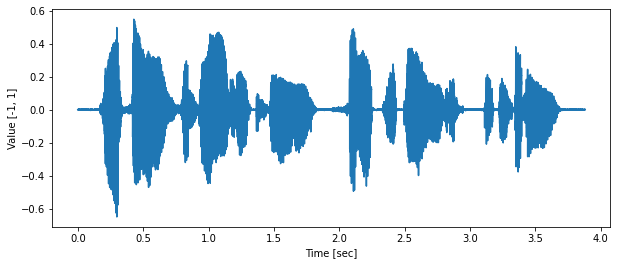

In [40]:
plt.figure(figsize=(10, 4))
plt.xlabel("Time [sec]")
plt.ylabel("Value [-1, 1]")
plt.plot(x, data)
plt.show()

# 2.4 白色雑音をグラフ化

In [45]:
n_sample = 40000
sample_rate = 16000
np.random.seed(0)
data = np.random.normal(size=n_sample)
x = np.array(range(n_sample))/ sample_rate

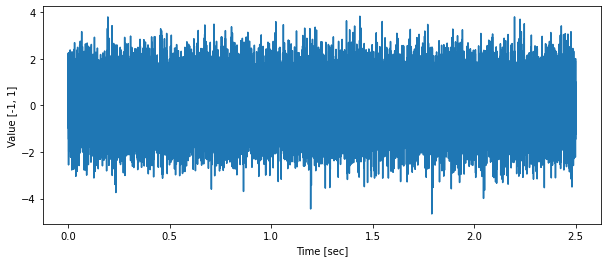

In [46]:
plt.figure(figsize=(10, 4))
plt.xlabel("Time [sec]")
plt.ylabel("Value [-1, 1]")
plt.plot(x, data)
plt.show()

# 2.5 ファイルに音声データを書き込む

In [47]:
np.random.seed(0)
data = np.random.normal(scale=0.1, size=n_sample)

In [49]:
# 音の情報
data_scale_adjust = data * np.iinfo(np.int16).max # スケールを16bitへ
with wave.open("./dataset/wgn_wave.wav", "w") as wave_out:
    wave_out.setnchannels(1)
    wave_out.setsampwidth(2)
    wave_out.setframerate(sample_rate)
    wave_out.writeframes(data_scale_adjust)


# 2.6 音声ファイルの再生

In [51]:
import sounddevice as sd

In [52]:
with wave.open(sample_wave_file) as wav:
    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)

    sd.play(data, wav.getframerate())
    print("再生開始")
    status = sd.wait()

再生開始


# 2.7 音声データを録音する

以下の録音では、ライブラリの内部で、8kHz以上をフィルタしてくれている

In [54]:
wave_length = 5 # sec
sample_rate = 16000

print("録音開始")
data = sd.rec(int(wave_length * sample_rate), sample_rate, channels=1)
sd.wait()

録音開始


# 2.10 stftによる短時間フーリエ変換

In [72]:
import scipy.signal as sp

In [73]:
with wave.open(sample_wave_file) as wav:
    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    frame_rate = wav.getframerate()
    f, t, stft_data = sp.stft(data, fs=wav.getframerate(), window="hann", nperseg=512, noverlap=256)

In [74]:
print(f"stft shape: {np.shape(stft_data)}")
print(f"周波数 [Hz]: {f[:5]} ...    {f[-5:]}")
print(f"time [sec]: {t[:5]} ... {f[-5:]}")

stft shape: (257, 244)
周波数 [Hz]: [  0.    31.25  62.5   93.75 125.  ] ...    [7875.   7906.25 7937.5  7968.75 8000.  ]
time [sec]: [0.    0.016 0.032 0.048 0.064] ... [7875.   7906.25 7937.5  7968.75 8000.  ]


# 2.11 短時間フーリエ変換で変換した信号のスペクトログラム表示

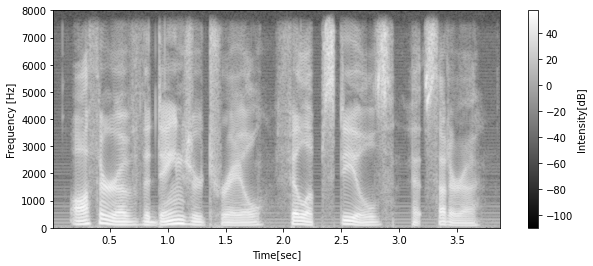

In [75]:
fig = plt.figure(figsize=(10, 4))
spectrum, freqs, t, im = plt.specgram(data, NFFT=512, noverlap=512/16*15, Fs=frame_rate, cmap="gray")
fig.colorbar(im).set_label("Intensity[dB]")
plt.xlabel("Time[sec]")
plt.ylabel("Frequency [Hz]")
plt.show()

# 2.12 短時間フーリエ変換により時間相は数領域の信号を時間領域の信号に戻す

In [76]:
t, data_post = sp.istft(stft_data, fs=frame_rate, window="hann", nperseg=512, noverlap=256)
data_post = data_post.astype(np.int16)

In [78]:
with wave.open("./dataset/istft_post_wave.wav", "w") as wave_out:
    wave_out.setnchannels(1)
    wave_out.setsampwidth(2)
    wave_out.setframerate(sample_rate)
    wave_out.writeframes(data_post)

# 2.13 特定の周波数成分を消し音を再生する

In [79]:
stft_data[100:, :] = 0
t, data_post = sp.istft(stft_data, fs=frame_rate, window="hann", nperseg=512, noverlap=256)
data_post = data_post.astype(np.int16)
with wave.open("./dataset/istft_post_wave.wav", "w") as wave_out:
    wave_out.setnchannels(1)
    wave_out.setsampwidth(2)
    wave_out.setframerate(sample_rate)
    wave_out.writeframes(data_post)

# 2.14 スペクトルサブトラクションによる雑音抑制

In [110]:
with wave.open(sample_wave_file) as wav:
    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    frame_rate = wav.getframerate()
    n_spech = wav.getnframes()

In [111]:
# 白色雑音
n_noise_only = 40000
n_sample = n_noise_only + n_spech

wgn_signal = np.random.normal(scale=0.04, size = n_sample)
wgn_signal = wgn_signal * np.iinfo(np.int16).max
wgn_signal = wgn_signal.astype(np.int16)

In [112]:
# 混合音の作成
mix_signal = wgn_signal
mix_signal[n_noise_only:] += data

In [113]:
f, t, stft_data = sp.stft(mix_signal, fs=frame_rate, window="hann", nperseg=512, noverlap=256)
print(mix_signal.shape, stft_data.shape)

(102081,) (257, 400)


In [114]:
# 振幅の取得
amp = np.abs(stft_data)
# 位相の取得
phase = stft_data/ np.maximum(amp, 1.e-20)
print(phase.shape)
# 雑音のみの区間のフレーム数
n_noise_only_frame = np.sum(t < (n_noise_only / sample_rate))
print(n_noise_only_frame)

(257, 400)
157


In [127]:
# param
p = 1.
alpha = 20.

In [128]:
# 雑音振幅の推定
noise_amp = np.power(np.mean(np.power(amp, p)[:, :n_noise_only_frame], axis=1, keepdims=True), 1./2)
print(noise_amp.shape)

(257, 1)


In [129]:
eps = 0.01 * np.power(amp, p) # 入力振幅の1%を下回らないようにする

In [130]:
processed_amp = np.power(np.maximum(np.power(amp, p) - alpha * np.power(noise_amp, p), eps), 1./p)
print(processed_amp.shape)

#位相をかける
processed_stft_data = processed_amp * phase


# 時間領域に戻す
t, processed_data_post = sp.istft(processed_stft_data, fs=frame_rate, window="hann", nperseg=512, noverlap=256)

(257, 400)


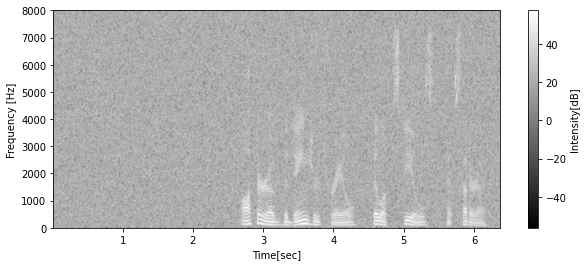

In [131]:
fig = plt.figure(figsize=(10, 4))
spectrum, freqs, t, im = plt.specgram(mix_signal, NFFT=512, noverlap=512/16*15, Fs=frame_rate, cmap="gray")
fig.colorbar(im).set_label("Intensity[dB]")
plt.xlabel("Time[sec]")
plt.ylabel("Frequency [Hz]")
plt.show()

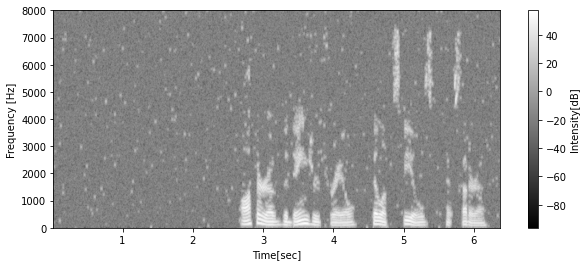

In [132]:
fig = plt.figure(figsize=(10, 4))
spectrum, freqs, t, im = plt.specgram(processed_data_post, NFFT=512, noverlap=512/16*15, Fs=frame_rate, cmap="gray")
fig.colorbar(im).set_label("Intensity[dB]")
plt.xlabel("Time[sec]")
plt.ylabel("Frequency [Hz]")
plt.show()

# 2.14 ウィナーフィルターによる雑音抑圧

In [133]:
# 混合音の作成
mix_signal = wgn_signal
mix_signal[n_noise_only:] += data

In [135]:
# 入力信号に関して
amp = np.abs(stft_data)
input_power = np.power(amp, 2.)

In [136]:
alpha = 1.
mu = 10

In [137]:
# 雑音のパワーを推定
noise_power = np.mean(np.power(amp, 2)[:, :n_noise_only_frame], axis=1, keepdims=True)

In [138]:
eps = 0.01 * input_power

In [140]:
processed_power = np.maximum(input_power - alpha * noise_power, eps)
wf_ratio = processed_power / (processed_power + mu*noise_power)
processed_stft_data = wf_ratio * stft_data
t, processed_data_post = sp.istft(processed_stft_data, fs=frame_rate, window="hann", nperseg=512, noverlap=256)

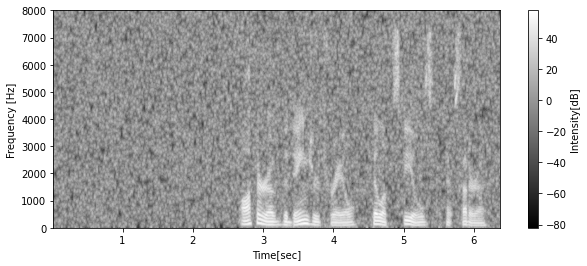

In [141]:
fig = plt.figure(figsize=(10, 4))
spectrum, freqs, t, im = plt.specgram(processed_data_post, NFFT=512, noverlap=512/16*15, Fs=frame_rate, cmap="gray")
fig.colorbar(im).set_label("Intensity[dB]")
plt.xlabel("Time[sec]")
plt.ylabel("Frequency [Hz]")
plt.show()